In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_csv(file):
    df = pd.read_csv(file, parse_dates=True, index_col=0)
    return df

## XGBoost for LSTM imputed dataset


In [3]:
X_train = read_csv('output/\lstm/\CompleteDengueTrainLSTM10_0.csv')
X_test = read_csv('output/\lstm/\CompleteDengueTestLSTM10_0.csv')

y = pd.read_csv('input/\dengue_labels_train.csv', parse_dates=True)

y = y.groupby(['year', 'weekofyear']).sum()
y_train = y.iloc[:734]
y_train = pd.DataFrame(index = X_train.index, data = y_train.total_cases.values)
y_test = y.iloc[734:]
y_test = pd.DataFrame(index = X_test.index, data = y_test.total_cases.values)


xgb_model = xgb.XGBClassifier(objective="reg:squarederror",
                                  eval_metric = 'rmse',
                                  max_depth=3,
                                  n_estimators=260,
                                  learning_rate=0.1
                              )
model = xgb_model.fit(X_train, y_train)

y_pred = model.predict(X_test)

MSE = mse(y_test, y_pred)
RMSE = np.sqrt(MSE)

print("\nRMSE: ", np.round(RMSE, 2))


RMSE:  27.63


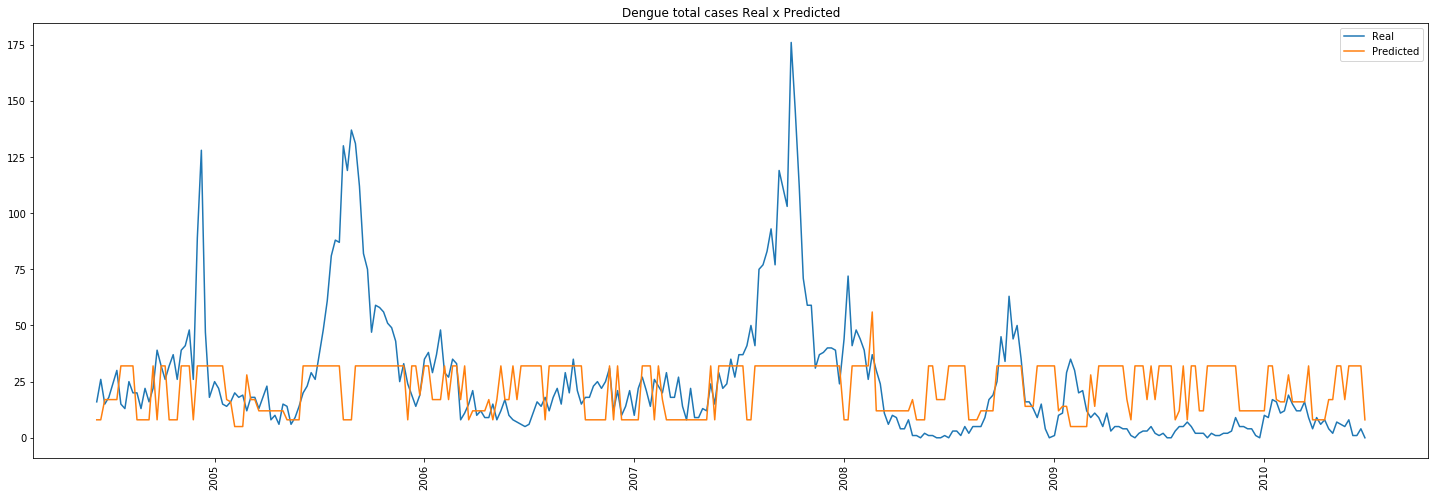

In [4]:
plt.figure(figsize=(25, 8))
plt.plot(y_test.index, y_test.values, label='Real')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title("Dengue total cases Real x Predicted")
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [7]:
def run_experiment_multiple_times( n=30):
    result_dict= {'rmse':0, 'best_model':None, 'best_rmse':999999999999}
    list_rmse = []
    for i in range(0,n):
        y = pd.read_csv('input/\dengue_labels_train.csv', parse_dates=True)
        y = y.groupby(['year', 'weekofyear']).sum()

        X_train = read_csv('output/\lstm/\CompleteDengueTrainLSTM10_'+str(i)+'.csv')
        X_test = read_csv('output/\lstm/\CompleteDengueTestLSTM10_'+str(i)+'.csv')
        y_train = y.iloc[:734]
        y_train = pd.DataFrame(index = X_train.index, data = y_train.total_cases.values)
        y_test = y.iloc[734:]
        y_test = pd.DataFrame(index = X_test.index, data = y_test.total_cases.values)
        xgb_model = xgb.XGBClassifier(objective="reg:squarederror",
                                          eval_metric = 'rmse',
                                          max_depth=3,
                                          n_estimators=260,
                                          learning_rate=0.1
                                      )
        model = xgb_model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        MSE = mse(y_test, y_pred)
        RMSE = np.sqrt(MSE)
        list_rmse.append(RMSE)
        print('Round', i, "rmse", RMSE)
        result_dict['rmse'] += RMSE
        if result_dict['best_rmse'] > RMSE:
            result_dict['best_rmse'] = RMSE
            result_dict['best_model'] = model
    print("STD RMSE", np.std(list_rmse, axis=0))
    result_dict['rmse'] = result_dict['rmse']/n
    return result_dict     

In [8]:
result_dict = run_experiment_multiple_times(n=30)

Round 0 rmse 27.62578735500813
Round 1 rmse 28.61590189509744
Round 2 rmse 31.82312227156712
Round 3 rmse 33.89657472043123
Round 4 rmse 33.890299216034975
Round 5 rmse 28.835108670915254
Round 6 rmse 30.65719315370362
Round 7 rmse 31.088863927738824
Round 8 rmse 28.613960406744294
Round 9 rmse 30.438801469844947
Round 10 rmse 33.33728547999377
Round 11 rmse 27.318404750190634
Round 12 rmse 28.562601811148475
Round 13 rmse 29.224419013329705
Round 14 rmse 28.306485879690946
Round 15 rmse 27.61779964339768
Round 16 rmse 28.15749357532457
Round 17 rmse 28.874001047792746
Round 18 rmse 27.876371060309545
Round 19 rmse 28.060139496649487
Round 20 rmse 31.254561571834902
Round 21 rmse 26.830745216800985
Round 22 rmse 28.775154627030656
Round 23 rmse 27.30102620316738
Round 24 rmse 33.181941923902976
Round 25 rmse 35.21845656100907
Round 26 rmse 29.404027366958175
Round 27 rmse 29.58249160439008
Round 28 rmse 30.91729879985257
Round 29 rmse 30.137831522670787
STD RMSE 2.2151643603699798


In [9]:
result_dict

{'rmse': 29.847471674751027,
 'best_model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
               gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', learning_rate=0.1, max_delta_step=0,
               max_depth=3, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=260, n_jobs=0,
               num_parallel_tree=1, objective='multi:softprob', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None),
 'best_rmse': 26.830745216800985}